In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import yfinance as yf
import seaborn as sns
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
pd.options.mode.chained_assignment = None
import tensorflow as tf
from zipfile import ZipFile
import keras
tf.random.set_seed(0)

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install keras-tuner
    !mkdir "logs/lstm_kt"
else:
    !pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00a 0:00:01


In [2]:
# Helper to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  #plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)

In [3]:
epochs = 50
ticker = "MSFT"
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 10  # length of output sequences (forecast period)
per = "1y"
layer_size = 4
batch = 4
metrics = ["mse"]

# Recurrent Neural Networks

The RNN type of network and its uses mirror that of a CNN - while the convolutional neural networks excel at capturing spatial relationships in data, RNNs excel at capturing temporal relationships, or things that change over time. This leads to this type of network to be well suited to time series types of problems, and also things like text processing, where the words that occur earlier in a sentence are connected to those that occur later. 

![RNN](images/rnn.png "RNN" )

The unique part of RNNs is that they can loop back, thus allowing the model to discover temporal relationships, or relationships that span over sequential data.

### RNN Structure

We will not focus much on a vanilla RNN model, we'll look at a variant - the Long Short-Term Memory model below. We should briefly look at the basics that make up a RNN. The structure of an RNN is similar to that of other neural networks, but with a few key differences:
<ul>
<li> The first is that the input is a sequence of data, rather than a single image. 
<li> The second is that the output is a sequence of data, rather than a single value. 
<li> The third is that the network has looping, which allows it to remember things that happened in the past.
</ul>

Clearly, the attributes of RNNs make them well suited to time series problems, where the input is a sequence of data, and the output is also a sequence of data; they are also heavily used in text processing and NLP problems, where the input is a sequence of words, and the output is also a sequence of words. Until relatively recently, RNNs were the state of the art for NLP problems, particularly generative models, but the advent of the Transformer architecture has made them less popular. 

### RNN Memory

The defining characteristic of a RNN model is that it holds a "state", or a memory of the data that came from previous time steps. In NLP applications this state remembers information from what came previously in a sentence. In a time series application, this state remembers information from previous time steps. Just as the convolution operation in a CNN captures spatial relationships, the RNN operation captures temporal relationships with this state. As the model progresses through the sequential data, the state that it holds both informs the output and is updated by the data in the current time step.

### Vanishing (or Exploding) Gradients

A main reason that plain implementations of RNN models aren't used all that much is the problem of vanishing, or sometimes exploding, gradients. Recall that the gradient when we are doing gradient descent is the slope of the loss curve with respect to the weights, and we use that gradient along with the learning rate to adjust the weights up or down to make a great model. One problem with a RNN is that we need to also perform that gradient descent update of weights back through the time steps that make up our model. This means that the gradient is multiplied by the weights at each time step, and if the weights are small we can end up with gradients that are basically flat (no slope, or gradient to the curve) which can mean that the weights aren't really "learning", as they aren't being adjusted substantially as the model trains. This is called the vanishing gradient problem, the opposite, exploding gradients, is when the gradient is large and compounds over time. the problem of vanishing gradients is most easy to think of by thinking about NLP problems. If we have a sentence such as:
<ul>
<li> "France is where I grew up, I speak fluent French."
</ul>
The early information that someone grew up in France will likely inform the language that they speak fluently. If our model is experiencing a vanishing gradient problem, it may not be able to reach "fluent" and then remember that France is in the memory, as the gradients going back through all the layers and all the time steps is so small that the problem of "I speak SOME LANGUAGE fluently" isn't able to be learned with the knowledge that "they are from France", as the small gradients aren't changing, or learning, all the way back to the early weights. We can visualize it like this, the early steps and the late steps have a connection that fades over time. 

![Vanishing Gradient](images/vanish_grad.jpeg "Vanishing Gradient" )

## Long Short Term Memory

Long Short Term Memory (lstm) models are a type of RNN that we can commonly use to make time series predictions. LSTM models function to "remember" certain data and carry that forward, and forget other data. This gives LSTM models the ability to combat the vanishing gradient problem and maintain a "better memory" than a plain implementation of a RNN. LSTM models work by holding a couple of "states", or memory, and control the flow of data through the network and into those states with a set of gates. These LSTM models are near state of the art for sequental problems, surpassed only recently by the Transformer architecture that is in large language models like the GPTs. 

![LSTM](images/lstm.png "LSTM" )

LSTM models have some internal magic that allows them to remember data:
<ul>
<li> Cell state (C) - the "long term memory" of the model.
<li> Hidden state (h) - the "short term memory" of the model.
<li> Forget gate (1) - determines which old data can be dropped.
<li> Input gate (2) - processes new data. 
<li> Output gate (3) - combines the "held" old data with the new data to generate the output. 
</ul>

### LSTM States

The LSTM model holds two types of memory, the long and the short term. Each step of the model's training involves updating both of these states with the new incoming data at that time step. Each state is passed from time step to time step through the model, and the new data is used to update the states by each gate. 

### LSTM Gates

The flow of data into the states is controlled by a series of gates, each using either the tanh or the signmoid activation functions, strategically. Each activation function serves a different purpose here:
<ul>
<li> Sigmoid - acts to scale the importance of weights. 
<li> Tanh - acts to embed the current state in a normalized space. 
</ul>

The gates are:
<ul>
<li> Forget gate - determines which data to forget. The forget gate uses the sigmoid activation function on the current input and the previous hidden state to determine which data to forget. This is passed up to the cell state and multiplied by the current cell state. This acts to raise values that are "important" and lower values that are "unimportant".
<li> Input gate - determines which data to update. This works in conjunction with the "candidate gate", which is the tanh part - techincally it is its own thing, but it is effectively half of the input gate. The input gate generates both a representation and an importance scale of the hidden state and input data with the tanh and sigmoid activation functions. The representation is then multiplied by the importance scale and added to the current cell state. This "adds" the new data to the current cell state, but only the data that is "important" is added.
<li> Output gate - determines which data to output. This takes a representation of the <i>new</i> cell state multiplied by the sigmoid activation function of the hidden state and input data. This takes the importance of the current time step combined with the understanding of the current state. This value is also what is ultimately output from the model, to go into the dense layers for the final prediction.
</ul>

### LSTM Model Data

We'll use the closing price as our target here, we can download the data from the yahoo finance API. One of the good things about using LSTM models is that they are much more accepting than the more basic ARIMA-ish models in terms of data preparation. We don't need to deconstruct the data to try to make it stationary as the model is much better able to capture the underlying patterns in the data. The ARIMA model is basically a linear regression model, which we know is not super great at capturing non-linear relationships. The LSTM model has no such restriction, and if we have enough data and a reasonably repeatable pattern in the data, we can likely capture that pattern in the model itself. Personally, I find all the elaborate time series data preparation to be a pain, using the LSTM appoach makes it much more similar to regular regression/classification problems.

In [4]:
# download the data
df = yf.download(tickers=[ticker], period=per)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-29,278.959991,281.140015,278.410004,280.510010,278.226532,25087000
2023-03-30,284.230011,284.459991,281.480011,284.049988,281.737701,25053400
2023-03-31,283.730011,289.269989,283.000000,288.299988,285.953064,32766000
2023-04-03,286.519989,288.269989,283.950012,287.230011,284.891815,24883300
2023-04-04,287.230011,290.450012,285.670013,287.179993,284.842194,25824300


In [5]:
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)
y.shape

(252, 1)

In [6]:

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)
print(y[:10])

[[0.03306266]
 [0.056057  ]
 [0.08366337]
 [0.07671321]
 [0.07638831]
 [0.05794079]
 [0.10509902]
 [0.09074377]
 [0.04813234]
 [0.05241947]]


#### Generate Data for Predictions

For each point in our data we generate additional data at that point. LSTM models expect data to always be a 3D tensor of the dimensions:
<ul>
<li> [batch_size, timesteps, feature]
</ul>

The outcome of this will be data where each time point is now no longer just 1 value, like a normal time series, but it is a bunch of dates - this  is the "long term" memory part. The X's shape is:
<ul>
<li> (# of rows of data, # of lookback rows, number of features)
<li> I.e. each "row" now has the past 60 values as part of it. 
</ul>

The Y's shape is:
<ul>
<li> (# of rows of data, # of forecasting rows, number of features)
<li> I.e. each row is a prediction into the future. 
</ul>

Each of the inputs for our data "remembers" the past 60 days into the past! This is what allows these models to do such a good job on sequential data. 

<Axes: xlabel='Date'>

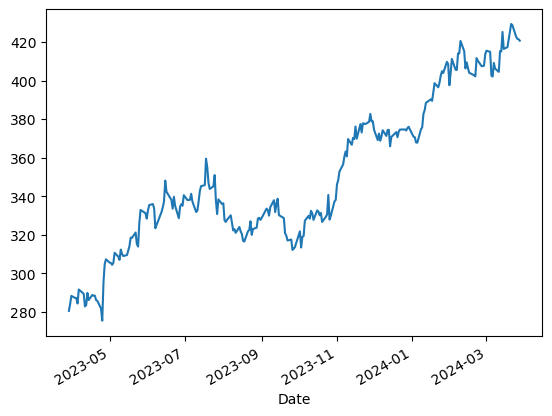

In [7]:
df['Close'].plot()

In [8]:
# generate the input and output sequences
X = []
Y = []

for i in range(n_lookback, len(y)):
    X.append(y[i - n_lookback: i])
    y_tmp = y[i: i + n_forecast]
    Y.append(y_tmp[0][0])

X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)

(192, 60, 1) (192,)


In [9]:
X[1]

array([[0.056057  ],
       [0.08366337],
       [0.07671321],
       [0.07638831],
       [0.05794079],
       [0.10509902],
       [0.09074377],
       [0.04813234],
       [0.05241947],
       [0.09366668],
       [0.06963301],
       [0.08691118],
       [0.08411811],
       [0.08463787],
       [0.06943796],
       [0.06716465],
       [0.041247  ],
       [0.        ],
       [0.12958742],
       [0.1910359 ],
       [0.2068204 ],
       [0.19577777],
       [0.19480347],
       [0.18824283],
       [0.19480347],
       [0.22884043],
       [0.2158492 ],
       [0.20513147],
       [0.23962318],
       [0.22533274],
       [0.21792785],
       [0.22111063],
       [0.23592063],
       [0.25060079],
       [0.2799609 ],
       [0.27879174],
       [0.29723926],
       [0.25878533],
       [0.24962648],
       [0.32802862],
       [0.37330307],
       [0.36239029],
       [0.3440728 ],
       [0.37128925],
       [0.38960693],
       [0.39311462],
       [0.37843447],
       [0.311

#### Fit Model

Our data is now ready to be used to fit a model, importantly, each X value is now a sequence containing the data of the past 60 days, rather than "just" a single value. So our input shape is now (60, 1). Each prediction takes in one value, and 60 time steps of it in the past; each prediction is a single value, and one time step of it. 

We can now make a model and train it. The long-short term memory layers are mostly simple to use, we need to be aware of a few things:
<ul>
<li> Input shape - this input shape is the size of the previous records and the number of features. Here we have 60 for the n_lookback and 1 for the number of features. 
<li> Return Sequences - this controls if the LSTM layers return everything or just the end result. We want all layers that are feeding another LSTM layer to return sequences, but the last LSTM layer should not.
<li> Output - each forecast gets its own output neuron, we are predicting exactly one time step value. 
</ul>

The units is our size parameter for each layer. Like in other models, the larger the size, the more complex the model can be, but the more likely it is to overfit. There are a few more notes on sizing below. 

In [10]:
# fit the model
model = Sequential()
model.add(LSTM(units=layer_size, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=layer_size))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=metrics)
history = model.fit(X, Y, epochs=epochs, batch_size=batch, verbose=1)
tmp = model.predict(X)

Metal device set to: Apple M2

systemMemory: 24.00 GB
maxCacheSize: 8.00 GB

Epoch 1/50


2024-03-31 15:29:50.844070: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


48/48 [==============================] - 2s 14ms/step - loss: 0.0974 - mse: 0.0974
Epoch 2/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0344 - mse: 0.0344
Epoch 3/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0226 - mse: 0.0226
Epoch 4/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0116 - mse: 0.0116
Epoch 5/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0066 - mse: 0.0066
Epoch 6/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0054 - mse: 0.0054
Epoch 7/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0052 - mse: 0.0052
Epoch 8/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0050 - mse: 0.0050
Epoch 9/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0045 - mse: 0.0045
Epoch 10/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0042 - mse: 0.0042
Epoch 11/50
48/48 [==============================] - 1s 13ms/step - lo

##### Print Results



<Axes: title={'center': 'MSFT'}, xlabel='Date'>

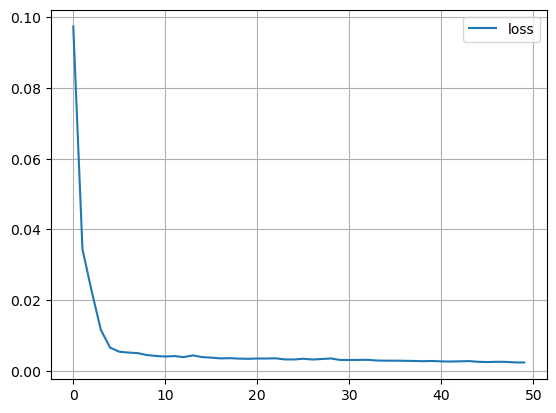

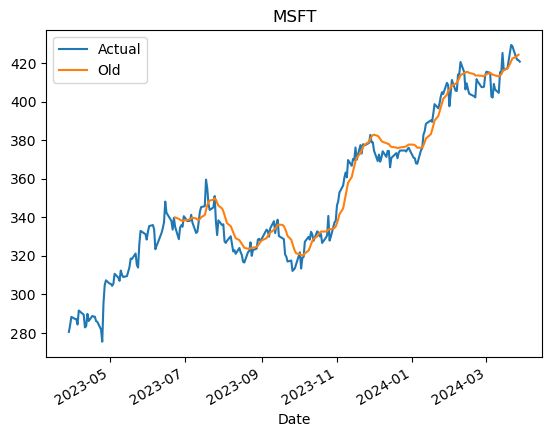

In [11]:
# Print
old_preds = []
for i in range(len(tmp)):
    old_preds.append(tmp[i][0])

# organize the results in a data frame
df_past = df[['Close']].reset_index()
#print(len(df_past))
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])

df_past['Old'] = np.nan
for i in range(len(old_preds)):
    df_past["Old"].iloc[i+n_lookback-1] = scaler.inverse_transform(np.array(old_preds[i]).reshape(1,-1))

results = df_past.set_index('Date')
# plot the results
plot_loss(history)
results.plot(title=ticker)

In [12]:
df_tmp = df_past[~df_past["Old"].isna()]
trainScore = math.sqrt(mean_squared_error(df_tmp["Actual"], df_tmp["Old"]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 6.52 RMSE


## Forward Forecasts - Model with Larger Y

We can also try to predict more than one day into the future as a core feature of our model. With stats-based models, if we want to project multiple time steps into the future we have to use our initial predictions to feed the later predictions. With a LSTM we can generate a standard output prediction that is multiple timesteps to begin with. To do this we need to change the shape of the Y data that is being predicted, rather than predicting one value, we can create a Y set that is the next 10 values, giving us 2 weeks of price forecasts. So, for each date in the data, we have:
<ul>
<li> X data this is the past 60 days of data. 
<li> Y data this is the next 10 days of data.
</ul>

These two values are the middle dimension of our data, the number of time steps. So, we need to make our dataset to model this - each prediction is now a sequence of 10 values, rather than a single value. Our 10 day future prediction isn't a run of the "next 10" predictions that come from the end of our model, they are one unitary output of our model that is 10 values long! Note that we can use the other method of feeding in predictions that we generate as a source for the next time-step's prediction, but this appoach is more elegant, normally easier to implement, and makes our model more "complete" in the sense that it will always generate its full output in one go. This may or may not be more accurate, that is not assured. 

In [13]:
def stockPredPrep(data, column="Close", n_lookback=60, n_forecast=10):
    scaler = MinMaxScaler(feature_range=(0, 1))
    y = data[[column]].fillna(method='ffill')
    y = scaler.fit_transform(y)
    start = n_lookback
    end = len(y) - n_forecast
    #end = len(y)
    X = []
    Y = []
    print(start,end)
    for i in range(start, end):
        X.append(y[i - n_lookback: i])
        y_tmp = y[i: i + n_forecast]
        Y.append(np.array(y_tmp))
    return np.array(X), np.array(Y), scaler

In [14]:
X_p, Y_p, scaler_p = stockPredPrep(df, n_lookback=n_lookback, n_forecast=n_forecast)
print(X_p.shape, Y_p.shape)
print(Y_p[0])

60 242
(182, 60, 1) (182, 10, 1)
[[0.34543682]
 [0.38421566]
 [0.39253004]
 [0.38733343]
 [0.4229945 ]
 [0.40643056]
 [0.40746988]
 [0.42773617]
 [0.401429  ]
 [0.36641754]]


### Multi-Step Predictions

Each y value is now a sequence of 10 values - the next 10 days of price. The output layer of our network also needs to be rearranged to match this, with one neuron for each prediction that is part of one Y value. This also changes the way the model is being trained, as now the 10 timestep prediction is the thing that is being evaluated for loss. We are technically not creating the model that minimizes the loss of one prediction, we are creating the model that minimizes the loss of the 10 predictions. Whether this is good or bad depends somewhat on perspective. It does make the structure of the model easier to use, as we don't need to feed predictions back into a model to get longer range predictions. This note is important, in a normal time-series model we were always generating predictions for the next time step in some ever-rolling manner if we wanted to make projections farther into the future (potentially outside of the Facebook Prohet models, which are more sophisticated internally). This means that there was no direct relationship in those models between "now" and "2 weeks from now" in the model, we were basically trusting that our "tomorrow" predictions would stack up to be accurate into the future. This is also a reason that deconstructing the trends and cyclicality of the data in those time series models was very important, we needed that so the model knew how to structure the patterns of its predictions.

In a multi-step prediction with our LSTM model we can construct our target for the model itself to by "N timesteps" rather than the next time step, like we are used to. This means that we are always generating a "N step" prediction and always evaluting the accuracy of those N steps when calculating the loss and optimizing our model. The result here is a "real" prediction that "based on the current information at this time step, we expect the value N steps ahead to be M", and that prediction will be based on the accuracy of the previous "N days out" predictions that we've made during training. Combined with the large capacity of the models and the ability to construct deep models, this opens the door to the accurate "far out" forecasting that models are capable of, given substantial data. This isn't a guarantee that these multi-step predictions will be the most accurate, we are still predicting something that hasn't happened yet, and reality is tricky. This is also one of the most relatable reasons I can think of to define a custom loss function, the way we treat error for predictions of tomorrow vs predictions of 2 weeks from now can reasonably be very different in different scenarios. For example, a stock price forecasting model needs to be very accuracte (potentially less than a cent) for predictions used to make automated high frequency trading decisions, but it doesn't need to be as accurate for predictions of stocks that are likely to climb over the next year. Defining a custom loss function that evaluates the accuracy of a model's predictions based on the real world impact of those errors is pretty likely if a time series model is fit into a very specific situation. 

#### Modelling Options

We can also try adding some more complexity to the model, just like any other network. One note is that if we add more lstm layers, we need to turn on the return sequences flag, so we are passing all the data to the next layer. This is basically a "keep LSTMing" or "stop LSTMing" flag that we always leave off on only the final LSTM layer and never think about again. There are a few other things that we <i>could</i> do with a model using this and another similar option, return_state, that returns the hidden state information. These can be used to develop customized architectures when using LSTM in functional models - the kind that we can customize almost limitlessly. Doing this is generally both complex and context dependent, for example, if we were developing audio recognition models for a company like Shazam (phone app that hears a song and looks it up for you) we may want to take advantage of things like this to create a model that is specifically good at exactly what we want to do. The Shazam model needs to extract a song from other audio like talking in an often noisy environment, process the audio that has been "distorted" by different audio systems (e.g. nightclub, car radio, tiny built in TV speakers...), match it to one of all other songs (bazillion way softmax classification?) based on any small clip, and do all of this within a couple of seconds. I am definately not in charge of audio engineering at Shazam, but I can go out on a pretty stable limb and say that they have models that are highly tailored to specific aspects of audio processing that are far more important for the odd challenge they have at hand. Long story short, this is one of the things that one could use to create such types of models, but it goes beyond our scope. 

In [15]:
# fit the model
model = Sequential()
model.add(LSTM(units=layer_size, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=layer_size))
model.add(Dropout(0.2))
model.add(Dense(10))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=metrics)
history = model.fit(X_p, Y_p, epochs=epochs, batch_size=batch, verbose=1)
tmp = model.predict(X_p)

Epoch 1/50
46/46 [==============================] - 2s 17ms/step - loss: 0.3162 - mse: 0.3162
Epoch 2/50
46/46 [==============================] - 1s 15ms/step - loss: 0.2368 - mse: 0.2368
Epoch 3/50
46/46 [==============================] - 1s 16ms/step - loss: 0.1576 - mse: 0.1576
Epoch 4/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1107 - mse: 0.1107
Epoch 5/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0704 - mse: 0.0704
Epoch 6/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0543 - mse: 0.0543
Epoch 7/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0450 - mse: 0.0450
Epoch 8/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0381 - mse: 0.0381
Epoch 9/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0307 - mse: 0.0307
Epoch 10/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0272 - mse: 0.0272
Epoch 11/50
46/46 [==============================] - 1s 19m

##### Check a Prediction

We can check a prediction to see what it looks like. The final prediction is now 10 numbers long, we have 10 predictions for the next 10 days!

In [16]:
scaler_p.inverse_transform(tmp[-1].reshape(-1, 1))

array([[399.72714],
       [391.97702],
       [389.3124 ],
       [408.10385],
       [395.4817 ],
       [400.75595],
       [398.2849 ],
       [392.445  ],
       [408.55713],
       [405.05933]], dtype=float32)

##### Plot Predictions

Because we have a bunch of predictions for each individual record, we need to collapse them together somehow to be able to make a simple plot of our predictions. There are several ways to do this, depending on what you want, but here we will just take the average of the predictions for each day. This gives us one value for each day, which we can then plot. You might alternatively want to take the most recent, median, or a weighted average of the predictions - the full stacks of predictions is also returned, so alternate calculations are possible. We haven't investigated it here, but we are likely seeing some fairly inaccurate predictions for the predictions made 9 or 10 days in advance being averaged with some pretty accurate predictions for the predictions made 1 or 2 days in advance.

In [17]:
def mergePreds(preds, forecasts):
    tmp_preds = []
    mean_preds = []
    for i in range(len(preds)):
        end = i
        start = end - forecasts
        item_preds = []
        if start < 0:
            start = 0
        record = forecasts-1
        for n in range(start, end):
            item = preds[n][record]
            #print(item, item.shape, type(item))
            item_preds.append(item)
            record -= 1
        if len(item_preds) > 1:
            tmp_preds.append(item_preds)
            mean_preds.append(np.mean(item_preds))
    return tmp_preds, mean_preds

def plotStockPred(preds, real, scaler, y_size=10):
    # organize the results in a data frame
    df_past = real[['Close']].reset_index()
    #print(len(df_past))
    df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
    df_past['Date'] = pd.to_datetime(df_past['Date'])

    df_past['Old'] = np.nan
    for i in range(len(preds)):
        #df_past["Old"].iloc[i+n_lookback-1] = scaler.inverse_transform(np.array(preds[i]).reshape(1,-1))
        val = scaler.inverse_transform(preds[i].reshape(1,-1))[0][0]
        #print(i, val)
        df_past["Old"].iloc[i+n_lookback-1] = val

    results = df_past.set_index('Date')
    return results

<Axes: xlabel='Date'>

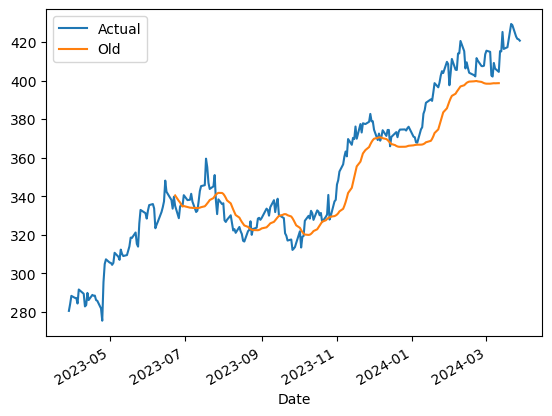

In [18]:
full_preds, mean_preds = mergePreds(tmp, n_forecast)

res = plotStockPred(mean_preds, df, scaler_p, n_forecast)
res.plot()

### Future Predictions

We can make predictions into the future, we just need to feed the model the data up to the most recent record, and then have it predict the next 10 days. Our input X value for each prediciton is one record of data, which we've seen contains the past 60 days of data. To make a prediction, we need to assemble our "last day" row of data that contains the previous 60 days worth of data that we need. 

In [19]:
future_data = stockPredPrep(df, n_forecast=0)
future_data[0][-1] # The last record

60 252


array([[0.62000645],
       [0.61825271],
       [0.60097434],
       [0.59974016],
       [0.64481975],
       [0.65196497],
       [0.69730424],
       [0.70938619],
       [0.73432934],
       [0.74602137],
       [0.74082495],
       [0.76940562],
       [0.8005847 ],
       [0.78655415],
       [0.80207857],
       [0.82585254],
       [0.8408574 ],
       [0.83475151],
       [0.87236118],
       [0.8650211 ],
       [0.7935043 ],
       [0.8337772 ],
       [0.88210461],
       [0.84592398],
       [0.84488465],
       [0.90048711],
       [0.90087683],
       [0.94270862],
       [0.90834695],
       [0.85027613],
       [0.87086712],
       [0.85183501],
       [0.83559597],
       [0.82734661],
       [0.82338418],
       [0.88489767],
       [0.87638843],
       [0.85820078],
       [0.85781106],
       [0.85936995],
       [0.89782408],
       [0.90990583],
       [0.90613846],
       [0.82643713],
       [0.8227996 ],
       [0.86859381],
       [0.84962652],
       [0.838

##### Shape and Predict

Mucho reshaping - we are getting the most recent set of data to predict for, since that'll give us a prediciton 10 days into the future. We are also reshaping that data - one batch, "however many" time steps, and one feature. So our shapes are:
<ul>
<li> X shape: (1, 60, 1) - one batch, 60 time steps, 1 feature
<li> Y shape: (1, 10, 1) - one batch, 10 time steps, 1 feature
</ul>

Both the X and Y are multidimensional here, but this is one record as far as the model is concerned. Similar to how with CNN models each record is a 2D (plus color depth) image, here each record is a 3D tensor. To make a prediction, we feed the X and get the Y, just as we are used to. 

In [20]:
future_preds = model.predict(future_data[0][-1].reshape(1,-1,1))
future_preds = scaler_p.inverse_transform(future_preds.reshape(-1, 1))
future_preds

1/1 [==============================] - 0s 56ms/step


array([[413.4589 ],
       [400.4357 ],
       [396.48914],
       [426.39047],
       [403.54517],
       [411.50494],
       [409.4954 ],
       [398.7542 ],
       [423.62418],
       [419.31918]], dtype=float32)

Combine with the old data. I will stack the original data together with the new predictions, and then plot the results.

In [21]:
df_pred = df["Close"]
df_pred = df_pred.to_frame()
df_pred["Date"] = df_pred.index

df_tmp = pd.DataFrame(columns=["Date", "Close"])
df_tmp["Date"] = pd.date_range(start=df_pred["Date"].iloc[-1] + pd.Timedelta(days=1), periods=len(future_preds))
df_tmp["Close"] = future_preds

df_pred.set_index("Date", inplace=True)
df_tmp.set_index("Date", inplace=True)

results = df_pred.append(df_tmp)
results.tail(10)


/var/folders/p1/m8wtcgx57417hx9d_r110ctw0000gn/T/ipykernel_83133/3708169377.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_pred.append(df_tmp)


,Close
Date,
2024-03-29,413.458893
2024-03-30,400.435699
2024-03-31,396.489136
2024-04-01,426.390472
2024-04-02,403.545166
2024-04-03,411.504944
2024-04-04,409.495392
2024-04-05,398.754211
2024-04-06,423.624176


##### Plot It

I am going to just shade the prediction part on the plot here. 

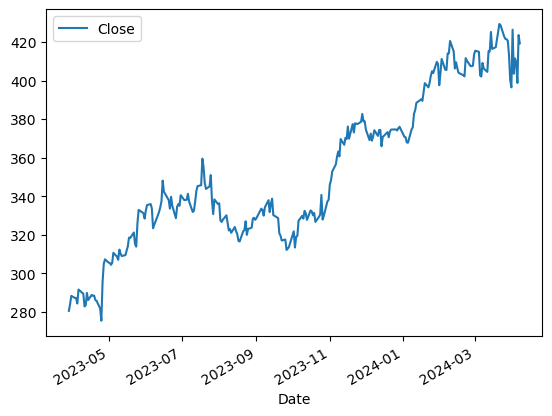

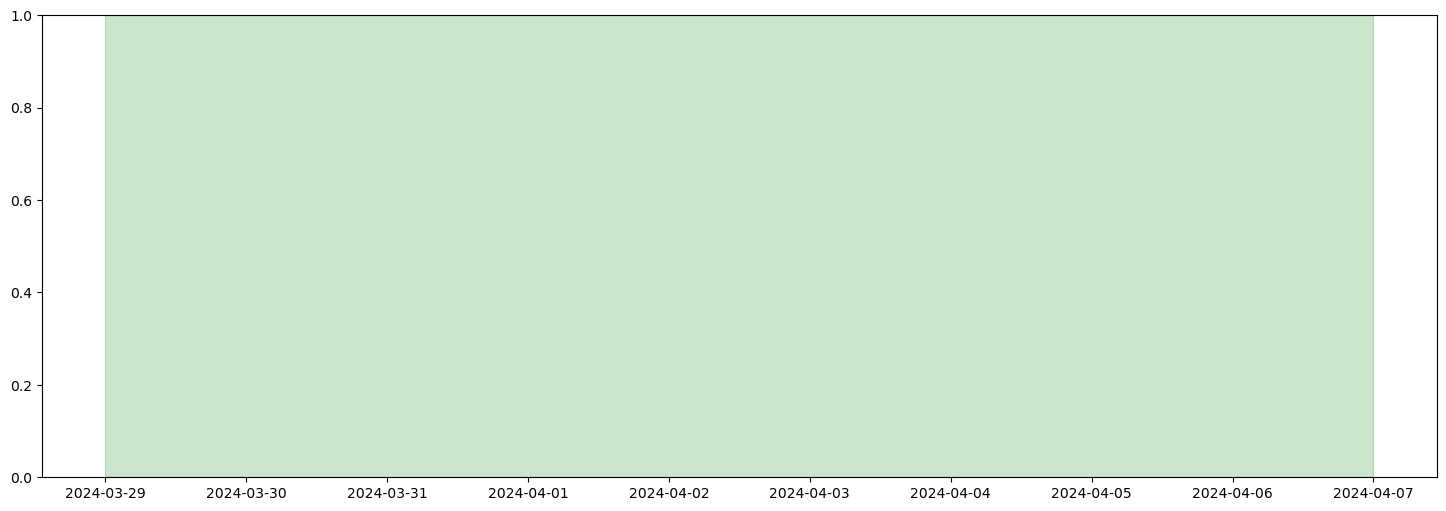

In [22]:
s = df_tmp.index[0]
e = df_tmp.index[-1]


results.plot()
plt.figure(figsize=(18,6))
plt.axvspan(s,e, color='g', alpha=0.2)

## Datasets with More Features

We can add more features to the model as well. One of the benefits to using a neural network is that adding more features does not require the same work and effort as with traditional time series models. Since we are generating a prediciton of N days into the future at any given time, we aren't restricted to the values that "we can know for the future" or offset calculations like we had to do with the ordinary time series models. The increased capacity of neural networks to learn relationships means that our model will accept more data with few changes.

Reconstructing the data to accomodate more features is a bit more cumbersome, we need to create data that is:
<ul>
<li> Y - the next N days of data. 
    <ul>
    <li> Shape - batch size, number of timesteps to predict, 1 value (usually). 
    </ul>
<li> X - the past N days of data, plus the features that we want to use.
    <ul>
    <li> Shape - batch size, number of timesteps to use (M days), number of features.
    </ul>
</ul>

So for any one prediction, the X input is the M day lookback of both the price and all the other features. The Y output is the next N days of price.

#### Nicer Data Prep Function

We can pair this with a more generalized function to prep our data. This one should, assuming I didn't mess it up, allow us to use any number of features and set the time windows to look both forward and backward to whatever we want. The columns parameter limits the data to those columns, and the y_col specifies which of these is the target. 

In [23]:
def prepare_stock_data(ticker, columns, y_col="Close", lookback=60, lookahead=10, timeframe="5y"):
    # Download stock prices for the past 5 years
    data = yf.download(ticker, period=timeframe)

    # Select the desired columns
    data = data[columns]

    # Prepare the data for an LSTM model
    x = []
    y = []
    for i in range(lookback, len(data)-lookahead):
        x.append(data.iloc[i-lookback:i].values)
        y.append(data[y_col][i:i+lookahead].values)
    x = np.array(x)
    y = np.array(y)

    # Reshape the data for the LSTM model
    x = np.reshape(x, (x.shape[0], x.shape[1], x.shape[2]))
    y = np.reshape(y, (y.shape[0], y.shape[1], 1))

    return x, y


For "real" predictions using the open, low, and close values doesn't make a lot of sense, but for a demonstration it's fine. 

In [24]:
columns = ["Close", "Volume", "Open", "High", "Low"]

x_tmp, y_tmp = prepare_stock_data("AAPL", columns=columns, y_col="Close", lookback=n_lookback, lookahead=n_forecast)
print(x_tmp.shape, y_tmp.shape)

[*********************100%%**********************]  1 of 1 completed

(1189, 60, 5) (1189, 10, 1)


##### Fit Model

The input shape for X is different now:
<ul>
<li> Batch size, by...
<li> Number of lookback timesteps (M days), by...
<li> Number of features (price + volume + whatever else)
</ul>

The output shape remains the same as before, we are still predicting 10 days into the future, so we output to 10 neurons and each output is a list of 10 individual predictions of one single value.

In [25]:
# fit the model
model = Sequential()
model.add(LSTM(units=layer_size, return_sequences=True, input_shape=(n_lookback, len(columns))))
model.add(LSTM(units=layer_size))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=metrics)
history = model.fit(x_tmp, y_tmp, epochs=epochs, batch_size=batch, verbose=1)

Epoch 1/50
298/298 [==============================] - 5s 14ms/step - loss: 19407.2734 - mse: 19407.2734
Epoch 2/50
298/298 [==============================] - 4s 14ms/step - loss: 18870.3008 - mse: 18870.3008
Epoch 3/50
298/298 [==============================] - 4s 14ms/step - loss: 18434.1309 - mse: 18434.1309
Epoch 4/50
298/298 [==============================] - 4s 14ms/step - loss: 18032.1660 - mse: 18032.1660
Epoch 5/50
298/298 [==============================] - 4s 14ms/step - loss: 17647.1211 - mse: 17647.1211
Epoch 6/50
298/298 [==============================] - 4s 14ms/step - loss: 17273.6660 - mse: 17273.6660
Epoch 7/50
298/298 [==============================] - 4s 14ms/step - loss: 16909.1934 - mse: 16909.1934
Epoch 8/50
298/298 [==============================] - 4s 14ms/step - loss: 16552.6406 - mse: 16552.6406
Epoch 9/50
298/298 [==============================] - 4s 14ms/step - loss: 16203.1201 - mse: 16203.1201
Epoch 10/50
298/298 [==============================] - 4s 14ms/s

### LSTM - Tuning Performance

Like any other neural network model, we can change some things to try to improve the performance of our model. Like any other network, the true test of our model will come down to experimentation and testing. 

#### Unit Size and Layers

The "number of neurons" argument in creating an LSTM layer is the number of units in the layer. This parameter defines the size of the hidden state vector that is passed between the layers and combines with the size of the input to define the rest of the sizes of the weight matricies. The units is not related to the time steps, it is better though of as roughly the size of the data that we are processing at each time step. This works like the number of neurons in a normal dense layer, the larger the value, the higher the capacity of that layer to learn. 

Adding layers to the LSTM model is the other general strategy to creating a more powerful model - the more layers we add, the more complex the model can be, and the more it can learn. The basic structure of an LSTM model is similar to what we saw in a CNN, we have the "specialized stuff" in the first layers, either LSTM or CNN, then we add on some amount to dense layers to generate a final prediction. Models that have multiple LSTM layers are often called "stacked LSTM" models.

As with dense models, we need to decide how large to make our model in capacity, and how to balance that betweeen the two ways to add capacity - "width", or the number of units in each layer, and "depth", or the number of layers. This is something that ultimately needs to be tested to be firmly determined, but we can use some rules of thumb to give us good starting points:
<ul>
<li> If we have a "simple" pattern, like the examples that were easy to predict with moving average based strategies, one LSTM layer should be enough, likely with fewer than 50 units, maybe far fewer. 
<li> For more complex patterns:
    <ul>
    <li> A good starting point is to use about 50 units the first LSTM layer. If the problem appears complex, and maybe one other layer with a similar number of units.
    <li> If the patterns in the data appear to be largely defined by <b>interactions between multiple input features</b> or by <b>pattern blocks</b>, such as those identified by technical stock trading above, then we should try more units. 
    <li> If the patterns in the data appear to be <b>highly abstract</b>, such as parts of speech/language being components of full sentences, then we should try more layers. This lines up with very deep models being good at things like language translation, the structure and capacity of the model is well suited to the problem of language, with very abstract relationships. This is conceptually similar to how deeper CNN models are able to transform images through multiple layers and extract useful features on which to base a prediction - the deep LSTM models are able to transform temporal data through multiple layers and extract useful features.
    </ul>
</ul>

The relative balance between the two ways to add capacity can't be too far out of balance, which is a guideline without specifics; we are less likely to see good results with an LSTM layer of 3,000 units and one layer, or 2 units and 75 layers. In general, things that are based on unstructured data such as NLP based applications will tend to be better suited with a deep model, things like a sales forecast can likely be well served by a more shallow model. The training times for very deep models with large timesteps can get very large, as can the memory requirements. There is a rule of thumb that we can use for an estimate for a total number of units, but it is, at best, a very rough guideline:
<ul>
<li> Units = samples in training data / ((# input neurons + # output neurons) * alpha)
<li> Where alpha is a constant normally between 2 and 10, with 5 being a good starting point.
</ul>

So an algorithmic approach to deciding on a rough starting size for a model would be to calculate the total neurons above, using an alpha that mirrors the complexity, then divide that by one layer for a simple problem, two or more for a complex problem. The farther we get from a simple time-series problem, the less likely this rule of thumb will be precise. 

#### Dropouts in LSTM

Dropout layers are commonly used in LSTM models as a way to prevent overfitting. There are two basic ways that dropout layers can be used in an LSTM model:
<ul>
<li> Dropout between LSTM layers. 
<li> Dropout after LSTM layers, before the output layer. 
</ul>

Of the two, placing the dropout between LSTM layers will generally give more variance in the impact of the layer - potentially in both directions. There are also many other varieties of dropout strategies being researched, all seeking to be situationally smarter variations of the standard dropout layer we've applied here. While dropout layers are extremely common to see in LSTM models, they are not certain to improve model performance and their usefullness needs to be tested to be truly evaluated. It may or may not be useful in any given scenario, I am somewhat skeptical of the general usefullness of placing dropouts between the LSTM layers and would tend to lean towards trying the second approach first, where we sit the dropout after the LSTM layers.

#### Keras Tuner

We can use the Keras Tuner to do some hyperparameter tuning for the best configuration. The same principles apply as with any other model, we need to define a search space, and then run the search. One thing that we can do to make our search space smaller and allow more time for productive search, we can likely create smaller models that visually seem to "follow the trend" if we plot the training data - take that model that looks decent, and search +/- some units, +/- some layers, and try some variations such as dropouts or an additional dense layer. 

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/lstm_kt")

In [27]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=4,max_value=128,step=4),return_sequences=True, input_shape=(n_lookback, len(columns))))
    for i in range(hp.Int('n_layers', 1, 5)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=4,max_value=128,step=4),return_sequences=True))
    model.add(LSTM(6))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(6))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(10))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=metrics)
    return model

In [28]:
import time
timstamp = str(time.strftime("%Y%m%d-%H%M%S"))
proj = "lstm_kt" + timstamp
bayesian_opt_tuner = kt.tuners.BayesianOptimization(
    build_model,
    objective='mse',
    max_trials=5,
    executions_per_trial=3,
    directory="logs/lstm_kt",
    project_name=proj,
    overwrite=True)
bayesian_opt_tuner.search_space_summary()

Search space summary
Default search space size: 4
input_unit (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 128, 'step': 4, 'sampling': 'linear'}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
lstm_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 128, 'step': 4, 'sampling': 'linear'}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [29]:
# Change this for a more realistic search, but much longer. 
#search_epochs = int(epochs/3)
search_epochs = 3
bayesian_opt_tuner.search(x_tmp, y_tmp,epochs=search_epochs,validation_split=0.2,verbose=1, callbacks=[tensorboard_callback])


Trial 5 Complete [00h 00m 54s]
mse: 15868.320638020834

Best mse So Far: 15868.320638020834
Total elapsed time: 00h 03m 06s


#### Hyperparameter Tuning Complete - Results

We can take a look at the results and take the best model to go do our predicting... 

In [30]:
best_model = bayesian_opt_tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 112)           52864     
                                                                 
 lstm_1 (LSTM)               (None, 60, 24)            13152     
                                                                 
 lstm_2 (LSTM)               (None, 60, 12)            1776      
                                                                 
 lstm_3 (LSTM)               (None, 60, 116)           59856     
                                                                 
 lstm_4 (LSTM)               (None, 60, 52)            35152     
                                                                 
 lstm_5 (LSTM)               (None, 60, 96)            57216     
                                                                 
 lstm_6 (LSTM)               (None, 6)                 2

## Exercise

Predict the temperature for the next 24 hours, the target column is "T (degC)". Use the past 30 days of data to do so as a starting point, if you run into resource issues, switch that to 15 or 7 and give it a try. If you have time, attempt to make a function that constructs both the X and Y data for you, and can take in a number of days to look back, a number of days to predict forward, and ideally, a list of columns to use as features. As well, test one feature vs a bunch of features, and see if you can get a better result with more features.

In [31]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

weather_dataframe = pd.read_csv(csv_path)
weather_dataframe.head(10)

13568290/13568290 [==============================] - 2s 0us/step


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


In [32]:
weather_dataframe.tail(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
420541,31.12.2016 22:30:00,1000.44,-4.08,269.05,-7.89,74.60,4.51,3.37,1.15,2.10,3.37,1293.55,1.27,2.48,192.1
420542,31.12.2016 22:40:00,1000.45,-4.45,268.68,-7.15,81.30,4.39,3.57,0.82,2.22,3.57,1295.24,0.80,1.44,183.8
420543,31.12.2016 22:50:00,1000.32,-4.09,269.05,-7.23,78.60,4.51,3.54,0.96,2.21,3.54,1293.37,1.25,1.60,199.2
420544,31.12.2016 23:00:00,1000.21,-3.76,269.39,-7.95,72.50,4.62,3.35,1.27,2.09,3.35,1291.71,0.89,1.30,223.7
420545,31.12.2016 23:10:00,1000.11,-3.93,269.23,-8.09,72.60,4.56,3.31,1.25,2.06,3.31,1292.41,0.56,1.00,202.6
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
420550,01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


##### Prepare Data

The data has records every 10 minutes, meaning each day is 6 * 24 = 144 records. We have many features that we could use to generate a model. I think that making a prediction for every 10 minutes is a bit much, so I am going to collapse the 6 rows per hour down to 1. This is an arbitrary choice that does surrender some information, but it will make our data much more manageable. With a massive amount of data that might cause us issues later, this also may help with resource usage...

I'm going to construct my datasets to be in this structure:
<ul>
<li> X - batch size, 720 time steps (30 days), 13 features. 
    <ul>
    <li> Each time step is the average of 6 individual time steps. 
    </ul>
<li> Y - batch size, 24 time steps (to predict - 1 day), 1 feature (temperature).
</ul>

You could structure the dataset differently here, but make sure that what is going in and out makes sense here, and that you can roughly picture what would change if we were to make some changes to our choices:
<ul>
<li> What if I wanted to predict the next 48 hours instead of 24?
<li> What if I wanted to predict the temperature every 30 minutes instead of every 10 minutes?
<li> What if I wanted to base my predictions on the past 60 days instead of 30?
<li> What if I wanted to use only wind velocity and barometric pressure as my features, instead of everything?
</ul>

It isn't really necissary that you do each of these, but you should be able to adapt your solution to accomodate these changes if you needed to, without it being totally confusing. Each change is just a reshaping of the data going into and out of our model. The multi-dimensional shape of the data isn't the most intuitive thing in the world, so it it totally fine if your mind doesn't immediately manipulate the data in your head. If you diagram out the dimensions, it should be doable though. 

In [33]:
PREDICTION_LENGTH = 24
LOOKBACK = 24*7
LEN = 6
EXERCISE_EPOCHS = 5
EXERCISE_BATCH = 8

In [34]:
def collapseHours(dataF, date_col="Date Time", spacing=LEN):
    i = 0
    processed = []
    while i < len(dataF):
        processed.append(dataF[i:i+spacing].mean())
        i += spacing
    tmp_df = pd.DataFrame(processed)
    tmp_df.columns = dataF.columns[1:]
    return tmp_df

In [35]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    collapsed = collapseHours(weather_dataframe, date_col="Date Time", spacing=LEN)
    collapsed.head()

Create a function to construct datsets for us. 

In [36]:
def prepare_weather_data(dataF, cols, y_col="T (degC)", lookback=720, lookahead=144):
    # Select the desired columns
    scaler = MinMaxScaler()
    data = dataF[cols]

    # Prepare the data for an LSTM model
    x = []
    y = []
    for i in range(lookback, len(data)-lookahead):
        x.append(data.iloc[i-lookback:i].values)
        y.append(data[y_col][i:i+lookahead].values)
    x = np.array(x)
    y = np.array(y)

    # Reshape the data for the LSTM model
    x = np.reshape(x, (x.shape[0], x.shape[1], x.shape[2]))
    y = np.reshape(y, (y.shape[0], y.shape[1], 1))

    return x, y

#### Only One Feature

Try with a strightforward model that only uses one feature, and see how well it does.

In [37]:
X_one, y_one = prepare_weather_data(collapsed, cols=["T (degC)", "wd (deg)"], y_col="T (degC)", lookback=LOOKBACK, lookahead=PREDICTION_LENGTH)
print(X_one.shape, y_one.shape)

(69900, 168, 2) (69900, 24, 1)


In [38]:
# fit the model
model = Sequential()
model.add(LSTM(units=layer_size, return_sequences=True, input_shape=(LOOKBACK, X_one.shape[2])))
model.add(LSTM(units=layer_size))
model.add(Dropout(0.2))
model.add(Dense(PREDICTION_LENGTH))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=metrics)
history = model.fit(X_one, y_one, epochs=EXERCISE_EPOCHS, batch_size=EXERCISE_BATCH, verbose=1)

Epoch 1/5
8738/8738 [==============================] - 274s 31ms/step - loss: 40.4382 - mse: 40.4382
Epoch 2/5
8738/8738 [==============================] - 266s 30ms/step - loss: 17.5313 - mse: 17.5313
Epoch 3/5
8738/8738 [==============================] - 269s 31ms/step - loss: 17.1031 - mse: 17.1031
Epoch 4/5
8738/8738 [==============================] - 269s 31ms/step - loss: 16.0873 - mse: 16.0873
Epoch 5/5
8738/8738 [==============================] - 269s 31ms/step - loss: 14.3877 - mse: 14.3877


#### Train Multi-Feature Model

Now that our data is prepared, we can model and predict. Note the input and output shapes in our model:
<ul>
<li> Input shape - the size of one batch: (# of time steps to look back) * (# of features)
<li> Output shape - the size of the output layer: (# of time steps to predict) * (# of targets)
</ul>

No matter how the data was processed above, it should fit this format for the LSTM model. 

<b>Note:</b> if the lookback and the prediction are large numbers, we are possibly going to run into performance issues in terms of either processing time or memory usage. Try turning down the lookback to 7 days instead of 30 to reduce memory usage. 

In [39]:
weather_columns = collapsed.columns
print("Columns Used:", weather_columns)
X_weather, y_weather = prepare_weather_data(collapsed, cols=weather_columns, y_col="T (degC)", lookback=LOOKBACK, lookahead=PREDICTION_LENGTH)
print(X_weather.shape, y_weather.shape)

Columns Used: Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')
(69900, 168, 14) (69900, 24, 1)


In [40]:
# fit the model
model = Sequential()
model.add(LSTM(units=layer_size, return_sequences=True, input_shape=(LOOKBACK, len(weather_columns))))
model.add(LSTM(units=layer_size))
model.add(Dropout(0.2))
model.add(Dense(PREDICTION_LENGTH))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=metrics)
history = model.fit(X_weather, y_weather, epochs=EXERCISE_EPOCHS, batch_size=EXERCISE_BATCH, verbose=1)

Epoch 1/5
8738/8738 [==============================] - 266s 30ms/step - loss: 78.6234 - mse: 78.6234
Epoch 2/5
8738/8738 [==============================] - 264s 30ms/step - loss: 46.5127 - mse: 46.5127
Epoch 3/5
8738/8738 [==============================] - 272s 31ms/step - loss: 30.5341 - mse: 30.5341
Epoch 4/5
8738/8738 [==============================] - 284s 32ms/step - loss: 29.0046 - mse: 29.0046
Epoch 5/5
8738/8738 [==============================] - 280s 32ms/step - loss: 29.3284 - mse: 29.3284
